In [12]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
import polars as pl
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import  Bidirectional, GRU, Dense, Dropout,LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from tqdm import tqdm
import os

In [ ]:
X_train = 

In [ ]:
class MyGRUModel(nn.Module):
    def __init__(self, num_unique_venues, num_unique_actions, embedding_dim, gru_units, num_classes):
        super(MyGRUModel, self).__init__()

        # Embeddings for categorical variables
        self.venue_embedding = nn.Embedding(num_unique_venues, embedding_dim)
        self.action_embedding = nn.Embedding(num_unique_actions, embedding_dim)
        self.trade_embedding = nn.Embedding(2, embedding_dim)

        # GRU with multiple layers
        self.gru = nn.GRU(
            input_size=embedding_dim * 3 + 18,
            hidden_size=gru_units,
            num_layers=2,
            batch_first=True,
            bidirectional=True,
            dropout=0.3
        )

        # Multi-Head Attention
        self.attention_heads = 4
        self.attention = nn.MultiheadAttention(
            embed_dim=gru_units * 2,  # GRU output is bidirectional
            num_heads=self.attention_heads,
            dropout=0.2,
            batch_first=True
        )

        # Dense layers for classification
        self.fc1 = nn.Linear(gru_units * 2 + 8, 128)  # Added room for global stats
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, num_classes)

        # Batch normalization and dropout
        self.batch_norm1 = nn.BatchNorm1d(128)
        self.batch_norm2 = nn.BatchNorm1d(64)
        self.dropout = nn.Dropout(p=0.4)

    def forward(self, x):
        # Extract embeddings for venue, action, and trade
        venue_emb = self.venue_embedding(x[:, :, 0].long())
        action_emb = self.action_embedding(x[:, :, 1].long())
        trade_emb = self.trade_embedding(x[:, :, 2].long())

        # Extract continuous features (price, volumes, etc.)
        continuous_features = x[:, :, 3:]  # Ensure dimensions match
        features = torch.cat((venue_emb, action_emb, trade_emb, continuous_features), dim=-1)

        # Pass data through GRU
        gru_out, _ = self.gru(features)

        # Multi-Head Attention
        attn_output, _ = self.attention(gru_out, gru_out, gru_out)

        # Global statistics
        mean_stats = torch.mean(gru_out, dim=1)
        std_stats = torch.std(gru_out, dim=1)
        global_stats = torch.cat((mean_stats, std_stats), dim=-1)

        # Combine attention output and global stats
        combined_features = torch.cat((attn_output.mean(dim=1), global_stats), dim=-1)

        # Pass the combined features through dense layers
        x = self.fc1(combined_features)
        x = self.batch_norm1(x)
        x = torch.nn.functional.gelu(x)
        x = self.dropout(x)

        x = self.fc2(x)
        x = self.batch_norm2(x)
        x = torch.nn.functional.gelu(x)
        x = self.dropout(x)

        output = self.fc3(x)  # Final output layer for classification
        return output


# Model parameters
embedding_dim = 8
gru_units = 64
num_classes = 24

# Initialize the model
model = MyGRUModel(
    num_unique_venues=6,
    num_unique_actions=3,
    embedding_dim=embedding_dim,
    gru_units=gru_units,
    num_classes=num_classes
)

# Move the model to GPU (if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Prepare the data
inputs = torch.tensor(X_train, dtype=torch.float32).to(device)
targets = torch.tensor(Y, dtype=torch.long).to(device)  # Use long for labels in classification

# Create DataLoader for batching
dataset = TensorDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)

# Set up the optimizer and loss function
optimizer = optim.AdamW(model.parameters(), lr=3e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()

# Print the model configuration
print("Modified GRU-based model configuration is OK")


In [ ]:
num_observations = X_train.shape[0]
epochs = (10_000 * 1000) // num_observations
for epoch in range(epochs):  # Example with 10,000 epochs
    model.train()  # Set the model to training mode
    for batch_inputs, batch_targets in dataloader:
        optimizer.zero_grad()  # Reset gradients
        outputs = model(batch_inputs)  # Pass the data through the model
        loss = criterion(outputs, batch_targets.argmax(dim=1))  # Calculate the loss
        loss.backward()  # Backpropagation
        optimizer.step()  # Update the weights
    print(f'Epoch [{epoch+1}/{str(epochs)}], Loss: {loss.item():.4f}')

In [19]:
# importation des différents fichiers dans l'environnement 
X_test = pd.read_csv("X_test_m4HAPAP.csv")
X_train = pd.read_csv("X_train_N1UvY30.csv")
y_train = pd.read_csv("y_train_or6m3Ta.csv")
num_classes = 24
Y= to_categorical(y_train['eqt_code_cat'], num_classes=num_classes)

In [20]:
# Variables catégorielles à encoder
categorical_columns = ['venue', 'action', 'side']

# Variables numériques
numeric_columns = ['price', 'bid', 'ask', 'bid_size', 'ask_size', 'flux']

# Encoding
for col in categorical_columns:
    le = LabelEncoder()
    X_train[col] = le.fit_transform(X_train[col])
    X_test[col] = le.transform(X_test[col])


In [21]:
X_train = X_train.merge(y_train, on = 'obs_id')

In [27]:
group_col='eqt_code_cat'
cols=['price', 'bid', 'ask', 'bid_size', 'ask_size', 'flux']
threshold=7

In [37]:
df = X_train
df

,obs_id,venue,order_id,action,side,price,bid,ask,bid_size,ask_size,trade,flux,eqt_code_cat
0,0,4,0,0,0,0.30,0.00,0.01,100,1,False,100,10
1,0,4,1,0,1,-0.17,0.00,0.01,100,1,False,100,10
2,0,4,2,1,0,0.28,0.00,0.01,100,1,False,-100,10
3,0,4,3,0,0,0.30,0.00,0.01,100,1,False,100,10
4,0,4,4,1,0,0.37,0.00,0.01,100,1,False,-100,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...
16079995,160799,4,61,1,0,1.32,0.01,0.06,735,261,False,-100,5
16079996,160799,0,70,0,0,0.06,0.01,0.06,735,361,False,100,5
16079997,160799,4,71,0,0,1.26,0.01,0.06,735,361,False,100,5
16079998,160799,4,72,0,0,1.26,0.01,0.06,735,361,False,100,5


In [28]:
stats = df.groupby(group_col)[cols].agg(['mean', 'std'])
stats.columns = ['_'.join(col).strip() for col in stats.columns] 
stats

In [38]:
stats

,price_mean,price_std,bid_mean,bid_std,ask_mean,ask_std,bid_size_mean,bid_size_std,ask_size_mean,ask_size_std,flux_mean,flux_std
eqt_code_cat,,,,,,,,,,,,
0,0.326864,244.311979,0.000027,0.006988,0.010293,0.106592,1119.964755,1211.561051,1147.836754,1204.579320,0.068706,176.911762
1,0.294431,244.142359,-0.000108,0.033359,0.071947,0.861021,216.918185,212.234866,201.423791,314.203573,0.002690,99.000094
2,0.982058,11.604307,0.000307,0.034648,1.022583,10.290731,186.419969,187.646382,189.073709,210.479808,0.034213,97.038877
3,0.125475,3.482658,0.000557,0.021087,0.143525,3.245651,308.127230,506.450328,305.982279,446.357861,-0.007455,107.867757
4,0.853382,8.199992,0.000032,0.008687,0.883976,8.025556,662.953563,799.700871,662.598113,869.794211,-0.117772,163.018573
5,1.189307,345.440584,0.000355,0.022169,0.606434,7.807343,236.740885,230.588653,237.603064,228.282298,0.083909,105.894553
6,3.966658,33.013562,0.000153,0.047259,3.977365,30.846413,175.042066,190.151062,188.398333,259.891263,-0.013784,115.483682
7,1.999544,345.605859,0.000250,0.033275,1.090260,15.229392,172.683225,187.889848,174.378119,188.870987,0.008646,101.708000
8,1.357141,244.475910,0.000066,0.032336,1.011080,10.080935,244.277054,369.764408,232.671263,288.548581,0.050042,206.055396


In [54]:
cols_to_check = ['price', 'bid', 'ask', 'bid_size', 'ask_size', 'flux']

def remove_outliers(df, group_col, cols, threshold=7):
    """
    Supprime toutes les lignes d'un `obs_id` si au moins une valeur est un outlier
    selon les statistiques calculées par `group_col`.

    Args:
        df (pd.DataFrame): Le DataFrame d'entrée.
        group_col (str): La colonne pour grouper les calculs de moyenne et d'écart-type.
        cols (list): Les colonnes sur lesquelles appliquer la logique de suppression des outliers.
        threshold (float): Le seuil d'écart-type pour définir les outliers.

    Returns:
        pd.DataFrame: Le DataFrame sans les `obs_id` ayant des outliers.
    """
    # Calcul des moyennes et écarts-types par group_col
    stats = df.groupby(group_col)[cols].agg(['mean', 'std'])
    stats.columns = ['_'.join(col).strip() for col in stats.columns]  # Flatten multi-index columns

    # Joindre les stats au DataFrame initial
    df = df.merge(stats, on=group_col, how='left')

    # Calculer un masque booléen pour détecter les lignes avec des outliers
    outlier_flags = [
        (np.abs(df[col] - df[f"{col}_mean"]) > threshold * df[f"{col}_std"])
        for col in cols
    ]
    outlier_mask = np.logical_or.reduce(outlier_flags)  # Une seule condition True suffit

    # Identifier les `obs_id` contenant au moins un outlier
    obs_with_outliers = df.loc[outlier_mask, 'obs_id'].unique()

    # Supprimer tous les `obs_id` contenant des outliers
    return df[~df['obs_id'].isin(obs_with_outliers)].drop(columns=[f"{col}_mean" for col in cols] + [f"{col}_std" for col in cols])


# Appliquer la fonction sur X_train
X_train = remove_outliers(X_train, group_col='eqt_code_cat', cols=['price', 'bid', 'ask', 'bid_size', 'ask_size', 'flux'], threshold=7)

KeyboardInterrupt: 

/var/folders/3l/s4t1bsn973dfhyz_6q842jr00000gn/T/ipykernel_43763/1641231859.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=group_col, y=feature, data=df, ax=axes[i], palette="Set2")


KeyboardInterrupt: 

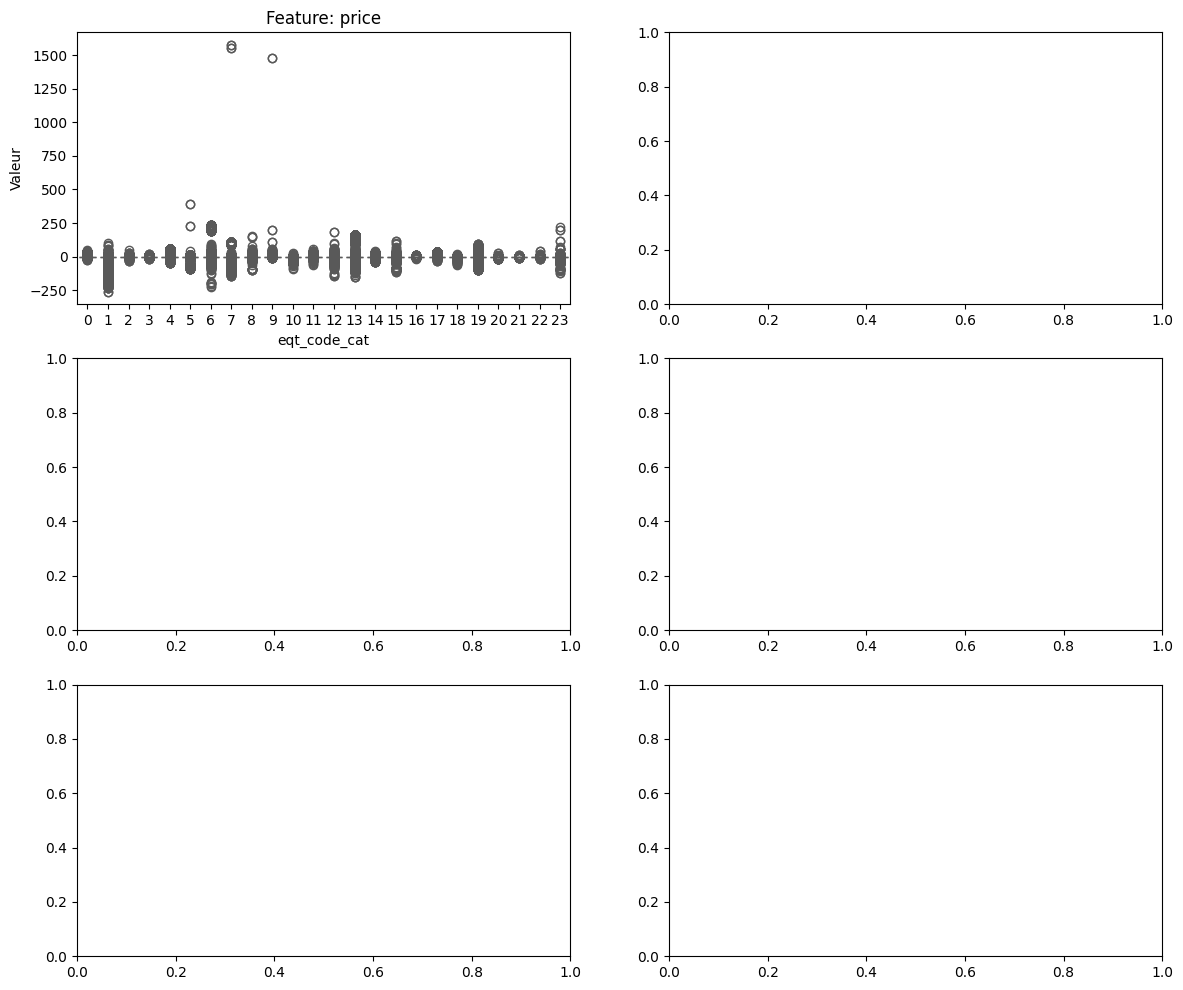

: 

In [56]:
import matplotlib.pyplot as plt 
features = [
    "venue",
    "order_id",
    "action",
    "side",
    "price",
    "bid",
    "ask",
    "bid_size",
    "ask_size",
    "trade",
    "flux",
]



import matplotlib.pyplot as plt
import seaborn as sns

def plot_sample(df, features, label, group_col, name="train"):
    """
    Trace des boxplots pour un ensemble de colonnes.
    
    Args:
        df (pd.DataFrame): DataFrame contenant les données.
        features (list): Liste des colonnes à tracer.
        label (str): Titre général pour les graphiques.
        group_col (str): Colonne utilisée pour grouper les données (facultatif pour des stats avancées).
        name (str): Nom de l'ensemble de données (e.g., 'train').
    """
    # Configurer la figure
    n_features = len(features)
    ncols = 2
    nrows = (n_features + 1) // ncols
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(14, 4 * nrows))
    axes = axes.flatten()  # Pour itérer facilement sur tous les axes
    
    # Supprimer les axes supplémentaires s'il y a un nombre impair de plots
    for ax in axes[n_features:]:
        ax.axis('off')
    
    # Tracer chaque feature
    for i, feature in enumerate(features):
        sns.boxplot(x=group_col, y=feature, data=df, ax=axes[i], palette="Set2")
        axes[i].set_title(f"Feature: {feature}", fontsize=12)
        axes[i].set_ylabel("Valeur")
        axes[i].set_xlabel(group_col)

    # Titre général pour la figure
    plt.suptitle(f"Label: {label} ({name})", fontsize=16, y=1.02)
    fig.tight_layout()
    plt.show()

# Exemple d'utilisation
features = [
    "price", "bid", "ask", "bid_size", "ask_size", "flux",
]
plot_sample(df=X_train, features=features, label="Example Label", group_col="eqt_code_cat", name="train")

In [51]:
for i in range(10):
    plot_sample(X_train[i], y_train[i])

KeyError: 0

In [5]:
def add_feature_engineering(df):
    # Bid-ask ratio and imbalance
    df['bid_ask_ratio'] = df['bid_size'] / (df['ask_size'] + 1e-6)
    df['Imbalance'] = df['bid_size'] - df['ask_size']

    # Price and spread features
    df['price_change'] = df.groupby('obs_id')['price'].diff()
    df['cumulative_price_change'] = df.groupby('obs_id')['price_change'].cumsum()
    df['bid_ask_spread'] = df['ask'] - df['bid']
    df['relative_spread'] = df['bid_ask_spread'] / (df['price'] + 1e-6)
    df['price_zscore'] = (df['price'] - df['price'].mean()) / df['price'].std()

    # Price position relative to bid and ask
    df['price_bid_ratio'] = df['price'] / (df['bid'] + 1e-6)
    df['price_ask_ratio'] = df['price'] / (df['ask'] + 1e-6)

    # Log-transformed sizes
    df['log_bid_size'] = np.log(df['bid_size'] + 1)
    df['log_ask_size'] = np.log(df['ask_size'] + 1)
    df['log_flux'] = np.log(np.abs(df['flux']) + 1) * np.sign(df['flux'])
    df['log_flux_change'] = df.groupby('obs_id')['log_flux'].diff()

    df.fillna(0, inplace=True)
    return df


X_train = add_feature_engineering(X_train)

/Users/thomasdeportzamparc/Desktop/Projects/1.Trading_bot/.venv/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [6]:
X_train.columns

Index(['obs_id', 'venue', 'order_id', 'action', 'side', 'price', 'bid', 'ask',
       'bid_size', 'ask_size', 'trade', 'flux', 'bid_ask_ratio', 'Imbalance',
       'price_change', 'cumulative_price_change', 'bid_ask_spread',
       'relative_spread', 'price_zscore', 'price_bid_ratio', 'price_ask_ratio',
       'log_bid_size', 'log_ask_size', 'log_flux', 'log_flux_change'],
      dtype='object')

In [7]:
selected_columns = ['venue', 'action', 'trade', 'bid', 'ask', 'price', 'bid_ask_ratio', 'Imbalance',
       'price_change','cumulative_price_change', 'bid_ask_spread','relative_spread', 'price_zscore', 'price_bid_ratio','price_ask_ratio','log_bid_size', 'log_ask_size', 'log_flux','log_flux_change']

def group_by_observation(X_train, selected_columns, sequence_length=100):
    grouped = X_train.groupby('obs_id')

    # Préallocation d'un tableau pour stocker toutes les séquences
    num_groups = len(grouped)
    sequences = np.zeros((num_groups, sequence_length, len(selected_columns)))  # Shape: (num_groups, sequence_length, num_features)

    for i, (_, group) in enumerate(grouped):
        # Prendre les sequence_length premiers événements si plus
        sequence = group[selected_columns].values[:sequence_length]

        # Si moins de sequence_length événements, on applique du padding (remplissage avec des zéros)
        if len(sequence) < sequence_length:
            sequences[i, :len(sequence)] = sequence  # Remplir les lignes avec les données existantes
            # Les lignes restantes sont déjà initialisées à zéro
        else:
            sequences[i] = sequence  # Remplacer par la séquence complète

    return sequences



# Utilisation de la fonction
X_train = group_by_observation(X_train, selected_columns)

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Définir un modèle avec LSTM, Attention et statistiques globales
class MyLSTMModel(nn.Module):
    def __init__(self, num_unique_venues, num_unique_actions, embedding_dim, lstm_units, num_classes):
        super(MyLSTMModel, self).__init__()

        # Embedding des catégories
        self.venue_embedding = nn.Embedding(num_unique_venues, embedding_dim)
        self.action_embedding = nn.Embedding(num_unique_actions, embedding_dim)
        self.trade_embedding = nn.Embedding(2, embedding_dim)

        # LSTM bidirectionnel avec plusieurs couches
        self.lstm = nn.LSTM(input_size=embedding_dim * 3 + 16, hidden_size=lstm_units, num_layers=2,
                            batch_first=True, bidirectional=True, dropout=0.3)

        # Mécanisme d'attention
        self.attention = nn.Linear(lstm_units * 2, 1)

        # Couches denses pour classification
        self.fc1 = nn.Linear(lstm_units * 2, 64)  # Couche linéaire après LSTM
        self.fc2 = nn.Linear(64, num_classes)  # Couche de sortie pour les classes

    def attention_mechanism(self, lstm_output):
        # Calculer les poids d'attention
        attention_weights = torch.nn.functional.softmax(self.attention(lstm_output), dim=1)
        # Appliquer les poids d'attention aux sorties LSTM
        weighted_sum = torch.sum(attention_weights * lstm_output, dim=1)
        return weighted_sum

    def forward(self, x):
        # Extraire les embeddings pour venue, action et trade
        venue_emb = self.venue_embedding(x[:, :, 0].long())
        action_emb = self.action_embedding(x[:, :, 1].long())
        trade_emb = self.trade_embedding(x[:, :, 2].long())

        # Extraire les caractéristiques continues (prix, volumes, etc.)
        continuous_features = x[:, :, 3:]  # Assurez-vous que les dimensions correspondent
        features = torch.cat((venue_emb, action_emb, trade_emb, continuous_features), dim=-1)

        # Passer les données dans LSTM
        lstm_out, _ = self.lstm(features)

        # Appliquer le mécanisme d'attention
        lstm_out_with_attention = self.attention_mechanism(lstm_out)

        # Passer la sortie à travers les couches denses
        output = self.fc1(lstm_out_with_attention)
        output = torch.nn.functional.selu(output)  # Activation SeLU
        output = self.fc2(output)  # Couches de sortie pour la classification

        return output


# Paramètres du modèle
embedding_dim = 8
lstm_units = 64
num_classes = 24

# Initialiser le modèle
model = MyLSTMModel(num_unique_venues=6, num_unique_actions=3, embedding_dim=embedding_dim,
                    lstm_units=lstm_units, num_classes=num_classes)

# Déplacer le modèle vers le GPU (si disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Préparer les données
inputs = torch.tensor(X_train, dtype=torch.float32).to(device)
targets = torch.tensor(Y, dtype=torch.long).to(device)  # Utiliser long pour les labels en classification

# Créer DataLoader pour le batching
dataset = TensorDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)

# Configuration de l'optimiseur et de la fonction de perte
optimizer = optim.Adam(model.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss()

# Afficher la configuration du modèle
print("Model configuration is OK")


Model configuration is OK


In [9]:
num_observations = X_train.shape[0]

In [10]:
epoques = (10_000 * 1000) // num_observations
for epoch in range(epoques):  # Exemple avec 10 époques
    model.train()  # Mettre le modèle en mode entraînement
    for batch_inputs, batch_targets in dataloader:
        optimizer.zero_grad()  # Réinitialiser les gradients
        outputs = model(batch_inputs)  # Passer les données dans le modèle
        loss = criterion(outputs, batch_targets.argmax(dim=1))  # Calculer la perte
        loss.backward()  # Rétropropagation
        optimizer.step()  # Mise à jour des poids
    print(f'Epoch [{epoch+1}/{str(epoques)}], Loss: {loss.item():.4f}')


KeyboardInterrupt: 

In [ ]:
X_test = add_feature_engineering(X_test)
X_test = group_by_observation(X_test, selected_columns)
X_test_input = torch.tensor(X_test, dtype=torch.float32).to(device)

In [ ]:
# Supposons que `test_dataset` contienne vos données de test
test_loader = DataLoader(X_test_input, batch_size=256, shuffle=False)

all_predictions = []
all_probabilities = []

model.eval()
with torch.no_grad():
    for batch_inputs in test_loader:  # Si vous avez besoin des cibles, sinon utilisez seulement batch_inputs
        batch_inputs = batch_inputs.to(device)

        # Faire la prédiction pour ce lot
        outputs = model(batch_inputs)
        probabilities = torch.softmax(outputs, dim=1)
        predicted_classes = torch.argmax(probabilities, dim=1)

        # Stocker les résultats
        all_predictions.append(predicted_classes.cpu().numpy())
        all_probabilities.append(probabilities.cpu().numpy())

# Combiner tous les lots
all_predictions = np.concatenate(all_predictions)
all_probabilities = np.concatenate(all_probabilities)

print("Prédictions pour tout le dataset :", all_predictions)


In [ ]:
# CSV Generation 
df_prediction = pd.DataFrame(data = {'eqt_code_cat':all_predictions})
df_prediction

In [ ]:
df_prediction.to_csv('ypredic.csv')

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Définir le modèle
class MyGRUModel2(nn.Module):
    def __init__(self, num_unique_venues, num_unique_actions, embedding_dim, gru_units, num_classes):
        super(MyGRUModel2, self).__init__()
        self.venue_embedding = nn.Embedding(num_unique_venues, embedding_dim)
        self.action_embedding = nn.Embedding(num_unique_actions, embedding_dim)
        self.gru = nn.GRU(input_size=embedding_dim * 2 + 7, hidden_size=gru_units, batch_first=True, bidirectional=True)
        self.fc1 = nn.Linear(gru_units * 2, 64)  # 2 car c'est bidirectionnel
        self.fc2 = nn.Linear(64, num_classes)

    def forward(self, x):
        venue_emb = self.venue_embedding(x[:, :, 0].long())
        action_emb = self.action_embedding(x[:, :, 1].long())
        
        # Concaténer les embeddings et les autres caractéristiques continues
        continuous_features = x[:, :, 2:]  # Assurez-vous que les dimensions correspondent
        features = torch.cat((venue_emb, action_emb, continuous_features), dim=-1)

        # Passer les données dans GRU
        gru_out, _ = self.gru(features)

        # On peut prendre la sortie de la dernière étape ou faire une autre opération ici
        output = self.fc1(gru_out[:, -1, :])
        output = torch.nn.functional.selu(output)
        output = self.fc2(output)
        return output


print ("class init done")
# Paramètres
embedding_dim = 8
gru_units = 64
num_classes = 24

# Instancier le modèle
model = MyGRUModel2(num_unique_venues=6, num_unique_actions=3, embedding_dim=embedding_dim, 
                   gru_units=gru_units, num_classes=num_classes)

# Déplacer le modèle vers le GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Préparer vos données
inputs = torch.tensor(X_train, dtype=torch.float32).to(device)
targets = torch.tensor(Y, dtype=torch.float32).to(device)

# Créer DataLoader
dataset = TensorDataset(inputs, targets)
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)

# Configuration de l'optimiseur et de la fonction de perte
optimizer = optim.Adam(model.parameters(), lr=3e-3)
criterion = nn.CrossEntropyLoss()

print("model configuration = OK ")


class init done
model configuration = OK 


In [13]:
print (len(dataloader))

161


In [2]:
pip install joblib


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [5]:
from joblib import dump, load

In [16]:
epoques = (10_000 * 1000) // num_observations
for epoch in range(epoques):  # Exemple avec 10 époques
    model.train()  # Mettre le modèle en mode entraînement
    for batch_inputs, batch_targets in dataloader:
        optimizer.zero_grad()  # Réinitialiser les gradients
        outputs = model(batch_inputs)  # Passer les données dans le modèle
        loss = criterion(outputs, batch_targets.argmax(dim=1))  # Calculer la perte
        loss.backward()  # Rétropropagation
        optimizer.step()  # Mise à jour des poids
    print(f'Epoch [{epoch+1}/{str(epoques)}], Loss: {loss.item():.4f}')


Epoch [1/62], Loss: 1.4806
Epoch [2/62], Loss: 1.4487
Epoch [3/62], Loss: 1.4453
Epoch [4/62], Loss: 1.3432
Epoch [5/62], Loss: 1.3676
Epoch [6/62], Loss: 1.3422
Epoch [7/62], Loss: 1.3667
Epoch [8/62], Loss: 1.3044
Epoch [9/62], Loss: 1.2901
Epoch [10/62], Loss: 1.2835
Epoch [11/62], Loss: 1.3083
Epoch [12/62], Loss: 1.2440


KeyboardInterrupt: 

In [17]:
sequences_bs = group_by_observation(X_test, selected_columns)

In [19]:
X_test_input = torch.tensor(sequences_bs, dtype=torch.float32).to(device)

In [20]:
model.eval()

MyGRUModel(
  (venue_embedding): Embedding(6, 8)
  (action_embedding): Embedding(3, 8)
  (gru): GRU(23, 64, batch_first=True, bidirectional=True)
  (fc1): Linear(in_features=128, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=24, bias=True)
)

In [1]:
with torch.no_grad():
    # Faire une prédiction
    predictions = model(X_test_input)

# Appliquer une fonction softmax pour obtenir les probabilités si le modèle n'a pas softmax dans sa dernière couche
probabilities = torch.nn.functional.softmax(predictions, dim=1)

# Obtenir les classes avec la probabilité la plus élevée
predicted_classes = probabilities.argmax(dim=1)

# Déplacer les résultats sur le CPU si nécessaire
predicted_classes = predicted_classes.cpu().numpy()

print(predicted_classes)  # Affiche les prédictions

NameError: name 'torch' is not defined

In [18]:
predictions = model.predict(sequences_bs)
y_predict_adjusted = np.argmax(predictions, axis=1)
df_prediction = pd.DataFrame(data = {'eqt_code_cat':y_predict_adjusted})
df_prediction

AttributeError: 'MyGRUModel' object has no attribute 'predict'

In [ ]:
df_prediction.to_csv('ypredic.csv')